# RL4CRN tutorial notebook: IC Classification (CVODE)

Refer to the Logic Circuits tutorial for more information about the overall pipeline.


In [1]:
import os, sys, numpy as np

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())


Python: 3.10.12
CWD: /local0/rossin/git/CRN-GenerativeAI/apps


## 1) Import RL4CRN helpers


In [2]:
from typing import Any, Callable, Dict, List, Sequence, Tuple, Union
import numpy as np
from itertools import product

from RL4CRN.utils.input_interface import (
    register_task_kind,
    overrides_get,
    Configurator,
    TaskKindBase,
    TaskSpec,
)

from RL4CRN.utils.default_tasks.ClassificationTaskKind import ClassificationTaskKind # <-- Gap searches for 2nd and 3rd habituation hallmarks

## 2) Build a template IO/CRN

Here we use the convenience builder `build_simple_IOCRN`, which provides an easy way to construct a I/O CRNs specifying dictionaries for input and output nodes.


In [3]:
from RL4CRN.utils.crn_builders import build_simple_IOCRN

# choose preset
cfg = Configurator.preset("paper")

# select simulator and set tolerances
cfg.solver.algorithm = "CVODE"
cfg.solver.rtol = 1e-6
cfg.solver.atol = 1e-6

# build template IO/CRN
species_labels = ['X_1', 'X_2']
crn, species_labels = build_simple_IOCRN(
    species=species_labels,
    production_input_map={"X_1": "u_1"},
    degradation_input_map={},
    dilution_map={},  # add dilution to ensure steady state exists
    production_map={},  # add basal production to X_2 nonzero peaks
    output_species=["X_1","X_2"],
    solver=cfg.solver,
)

print("Template CRN built.")
print(" - num_inputs:", crn.num_inputs)
print(" - num_species:", len(species_labels))
print(" - species:", species_labels)


Template CRN built.
 - num_inputs: 1
 - num_species: 2
 - species: ['X_1', 'X_2']


## 3) Build the reaction library (MAK)


In [4]:
from RL4CRN.utils.library_builders import build_MAK_library

# library components
library_components = build_MAK_library(crn, species_labels, order=2)

library, M, K, masks = library_components
print("Library built.")
print(" - M (num reactions in library):", M)
print(" - K (num parameters in library):", K)


Library built.
 - M (num reactions in library): 31
 - K (num parameters in library): 31


## 4) Define the task: RPA

- `kind="oscillator_mean"` selects the reward handler.
- `ic=("constant", 0.01)` sets initial concentrations.
- we use `u_values` to identify the combinations between input and disturbance
- we use `targets` to highlight the target output we seek to reach


In [5]:
ClassificationTaskKind.pretty_help()

### TaskKind `classification`

**Required params**
- `ic_r_maps`: List[(ic_values_block, r_value)]
- `u_list`: List[float] / List[List[float]] / np.ndarray
- `t_f`: float
- `n_t`: int

**Optional params**
- `weights`: weights spec for build_weights (default 'uniform')
- `norm`: int (default 1)
- `relative`: bool (default False)
- `LARGE_NUMBER`: float (default 1e4)


In [6]:
from RL4CRN.utils.input_interface import make_task, print_task_summary
import numpy as np
from RL4CRN.utils.default_tasks.ClassificationTaskKind import ic_builder_from_list

eps = 1e-3
ic_values_diagonal_1 = [[x/10, x/10 - 0.3] for x in range(3, 13)]
ic_values_diagonal_2 = [[x/10, x/10 + 0.3] for x in range(0, 10)]
ic_values_cluster_1  = [[.9, eps], [1, eps], [1.1, eps], [.9,.1], [1,.1], [1.1,.1]]
ic_values_cluster_2  = [[eps,.9], [eps,1], [eps,1.1], [.1,.9], [.1,1], [.1,1.1]]


task = make_task(
    template_crn=crn,
    library_components=library_components,
    kind="classification",
    species_labels=species_labels,
    params={
        "ic_r_maps": [(ic_values_diagonal_1, [1,0]), (ic_values_diagonal_2, [0,1]), (ic_values_cluster_1, [1,0]), (ic_values_cluster_2,[0,1])],
        "u_list": [1.],
        "t_f": 100.0,
        "n_t": 1000,
        "weights": ("uniform"),   
        "norm": 1,
        "relative": False,
        "LARGE_NUMBER": 1e4,
    },
)


print_task_summary(task)

# --- Optional safety checks (recommended) ---
print("Sanity checks:")
print(" - template num_inputs:", crn.num_inputs)
print(" - first u shape:", np.asarray(task.u_list[0]).shape)
print(" - first u length:", len(task.u_list[0]))

assert len(task.u_list[0]) == crn.num_inputs, "Input dimension mismatch: u has wrong length!"


Task: classification
time_horizon: (1000,) [0..100.0]
num scenarios: 1
first 1 u: [array([1.], dtype=float32)]

Sanity checks:
 - template num_inputs: 1
 - first u shape: (1,)
 - first u length: 1


## 5) Training configuration

We tune:
- `max_added_reactions`: episode length (how many reactions the agent can add)
- `epochs`: training iterations
- `render_every`: print progress cadence
- `seed`: reproducibility


In [7]:
# ---- Train config ----
cfg.train.max_added_reactions = 5
cfg.train.epochs = 11
cfg.train.render_every = 5
cfg.train.seed = 0

Rendering options

In [8]:
cfg.render.n_best = 100
cfg.render.disregarded_percentage = 0.9
cfg.render.mode = {  # Mode of the experiment
    'style': 'logger', 
    'task': 'phase_plot', 
    'format': 'image',
    'topology': True
}

## 6) Inspect full configuration (optional)

`cfg.describe()` prints a nested configuration dictionary.


In [9]:
cfg.describe()

{'task': None,
 'solver': {'algorithm': 'CVODE', 'rtol': 1e-06, 'atol': 1e-06},
 'train': {'epochs': 11,
           'max_added_reactions': 5,
           'render_every': 5,
           'hall_of_fame_size': 50,
           'batch_multiplier': 10,
           'seed': 0,
           'n_cpus': None,
           'batch_size': None},
 'policy': {'width': 1024,
            'depth': 5,
            'deep_layer_size': 10240,
            'continuous_distribution': {'type': 'lognormal_1D'},
            'entropy_weights_per_head': {'structure': 2.0, 'continuous': 1.0, 'discrete': 0.0, 'input_influence': 0.0},
            'ordering_enabled': False,
            'constraint_strength': inf},
 'agent': {'learning_rate': 0.0001,
           'entropy_scheduler': {'entropy_weight': 0.001,
                                 'topk_entropy_weight': 1.0,
                                 'remainder_entropy_weight': 1.0,
                                 'entropy_update_coefficient': 1,
                                 'e

## 7) Create session + trainer

This step wires together:
- parallel environments
- observer/tensorizer/actuator/stepper interfaces
- policy + agent
- the chosen task reward function

The returned object:
- `trainer`: runs rollout → reward eval → policy update loops


In [ ]:
import os
from datetime import datetime
from pytorch_lightning.loggers import CometLogger

task_name = "Classification_Task"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Expect these in your environment:
#   COMET_API_KEY   (required)
#   COMET_WORKSPACE (required)
api_key = os.environ["COMET_API_KEY"]
workspace = os.environ["COMET_WORKSPACE"]

logger = CometLogger(
    api_key=api_key,
    project=task_name,
    workspace=workspace,
    name=f"{task_name}_{timestamp}",
)

logger = logger.experiment


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/redsnic/classification-task/b18716629c144708b3b38d928e939418



In [11]:
from RL4CRN.utils.input_interface import make_session_and_trainer
trainer = make_session_and_trainer(cfg, task, logger=logger)

## 8) Train and save checkpoints

We run for `cfg.train.epochs` epochs and periodically save a checkpoint.


In [ ]:
# checkpoint_path = "habituation_task_chkpt.pkl"
checkpoint_path = "classification_task_chkpt.pkl"
trainer.run(epochs=cfg.train.epochs, checkpoint_path=checkpoint_path)


[cvHandleFailure, Error: -15] At t = 3.5594743694058, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 2.76082532969988, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 2.27463064091143, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 8.46652595122441, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 4.40201403346752, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 32.4851701869381, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 8.05547954879819, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 5.25697433125824, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 16.9883992713087, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 8.55755329009534, unable to satisfy inequality constraints.


[cvHandleF

/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:254: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:272: UserWarning: The figure layout has changed to tight
  fig1.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:254: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:272: UserWarning: The figure layout has changed to tight
  fig1.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:254: UserWarning: The figure layout has changed to tight
  fig.tight_layout(

Saved checkpoint: classification_task_chkpt.pkl

[cvHandleFailure, Error: -15] At t = 4.35490141212031, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 3.99303864799003, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 3.20818199664457, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 4.35766879696702, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 15.7444097416253, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 7.55900204790873, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 5.48111652685815, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 16.0586334838927, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 3.6182298395812, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 10.0276454913698, unable

## 9) Inspect the best CRN

The trainer keeps a **Hall of Fame** of good CRNs found during rollouts.


Best CRN loss: 0.35213314708190235
Inputs: ['u_1'] 
Species: ['X_1', 'X_2'] 
Output Species: ['X_1', 'X_2'] 
∅ ----> ∅;  [MAK(0.5386638045310974)]
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 ----> ∅;  [MAK(0.3795928359031677)]
X_1 ----> X_1 + X_1;  [MAK(0.6028356552124023)]
X_1 + X_1 ----> ∅;  [MAK(0.7176306247711182)]
X_1 + X_2 ----> X_2;  [MAK(0.5970684289932251)]
Hall of Fame size: 50
Best loss: 0.35213314708190235


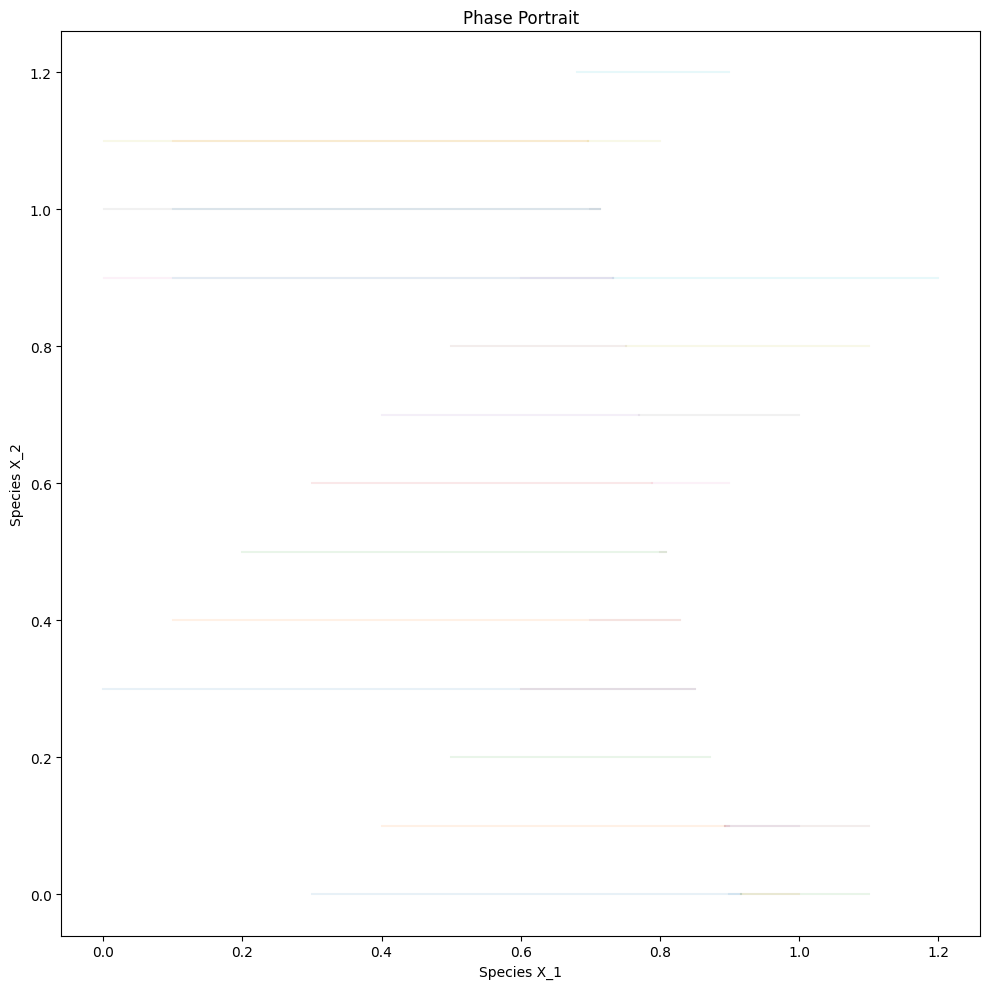

In [ ]:
trainer.inspect_best(plot=True)

best = trainer.best_crn()
print("Hall of Fame size:", len(trainer.s.mult_env.hall_of_fame))
if best is not None:
    print("Best loss:", best.last_task_info.get("reward", None))

HoF[3] loss: 0.3768702074216985
Inputs: ['u_1'] 
Species: ['X_1', 'X_2'] 
Output Species: ['X_1', 'X_2'] 
∅ ----> ∅;  [MAK(0.11539746820926666)]
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 + X_1 ----> ∅;  [MAK(0.6976426243782043)]
X_1 + X_2 ----> ∅;  [MAK(0.2372542768716812)]
X_1 + X_2 ----> X_1;  [MAK(0.14699582755565643)]
X_1 + X_2 ----> X_2 + X_2;  [MAK(0.3757462501525879)]


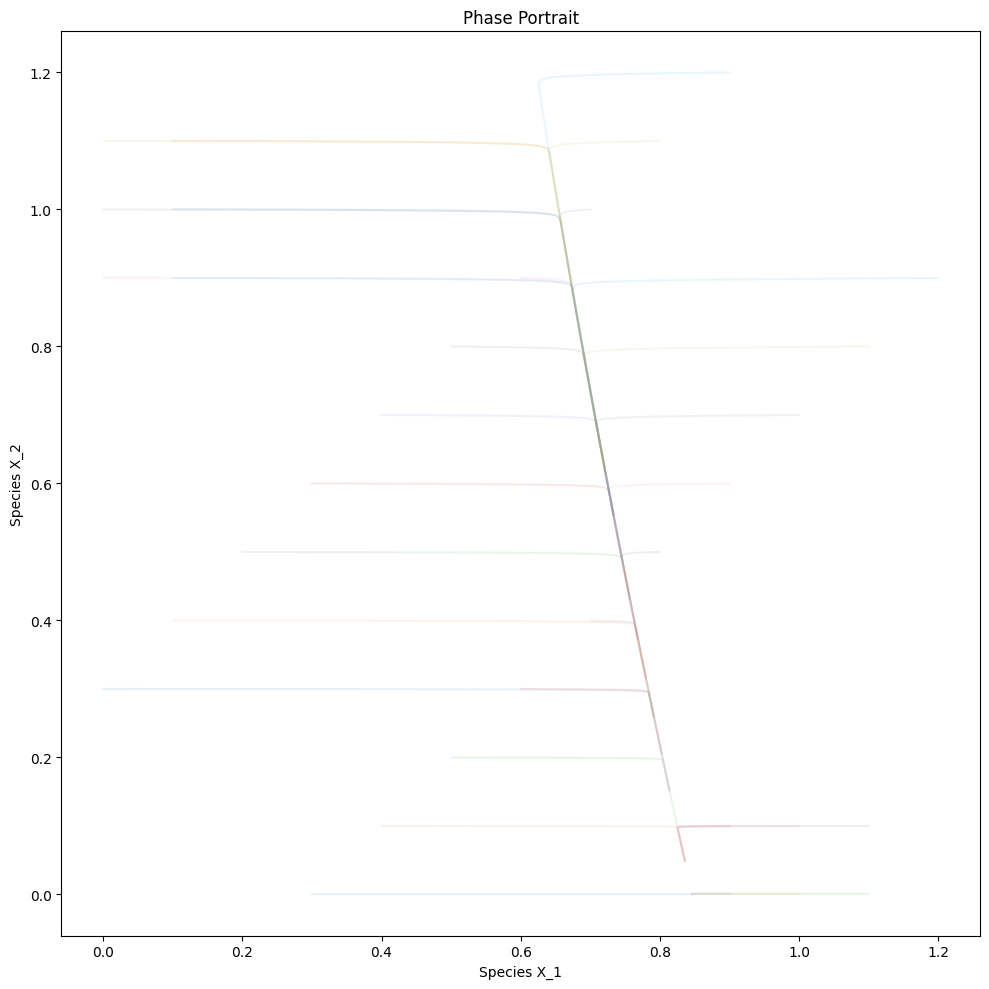

In [ ]:
index = 3
trainer.inspect_hof(index)

## 10) Sample and re-simulate

After training, we can **draw new CRN designs from the learned policy** (sampling runs in evaluation mode, i.e., no gradient updates) and **re-evaluate** them.

This is useful for:
- **Model exploration:** quickly inspect diverse candidates generated by the policy.
- **Controlled re-simulation:** re-run sampled CRNs under modified conditions (`u_list/u_spec`, `ic`, etc.).

Sampling produces a dedicated **sample Hall-of-Fame** that stores the best `K` sampled environments (lowest loss) for later inspection and checkpointing.


In [ ]:
trainer.sample(10, 10, ic=("constant", 1.0))

We can now inspect newly sampled I/O CRNs.

Inputs: ['u_1'] 
Species: ['X_1', 'X_2'] 
Output Species: ['X_1', 'X_2'] 
∅ ----> ∅;  [MAK(0.6979469060897827)]
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 ----> ∅;  [MAK(1.3348172903060913)]
X_1 + X_1 ----> ∅;  [MAK(0.7927143573760986)]
X_1 + X_2 ----> ∅;  [MAK(0.7126405835151672)]
X_2 + X_2 ----> X_2;  [MAK(0.6740201711654663)]
reward: 0.49684937821373354


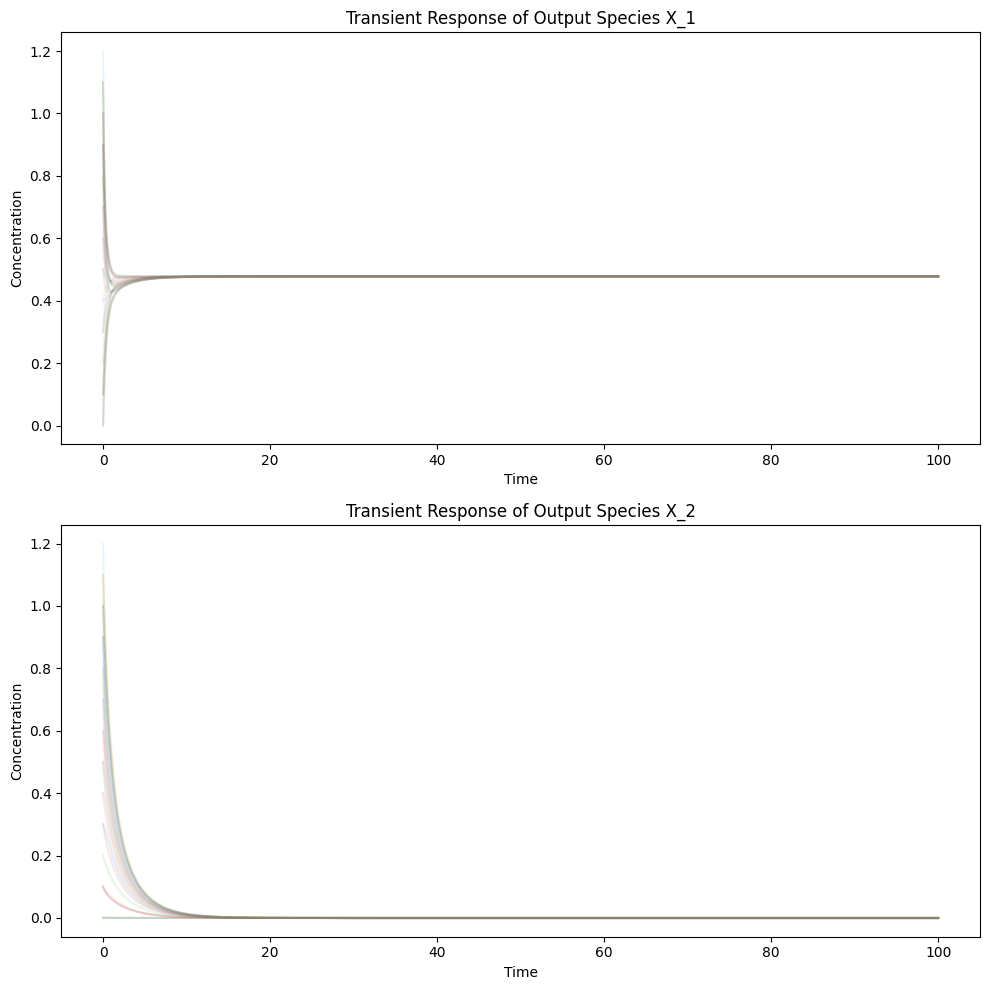

In [ ]:
import matplotlib.pyplot as plt

index = 0
crn_s = trainer.get_sampled_crns()[index]
print(crn_s)
print("reward:", crn_s.last_task_info.get("reward", None))

# Plotters depend on your IOCRN implementation
crn_s.plot_transient_response(); plt.show()


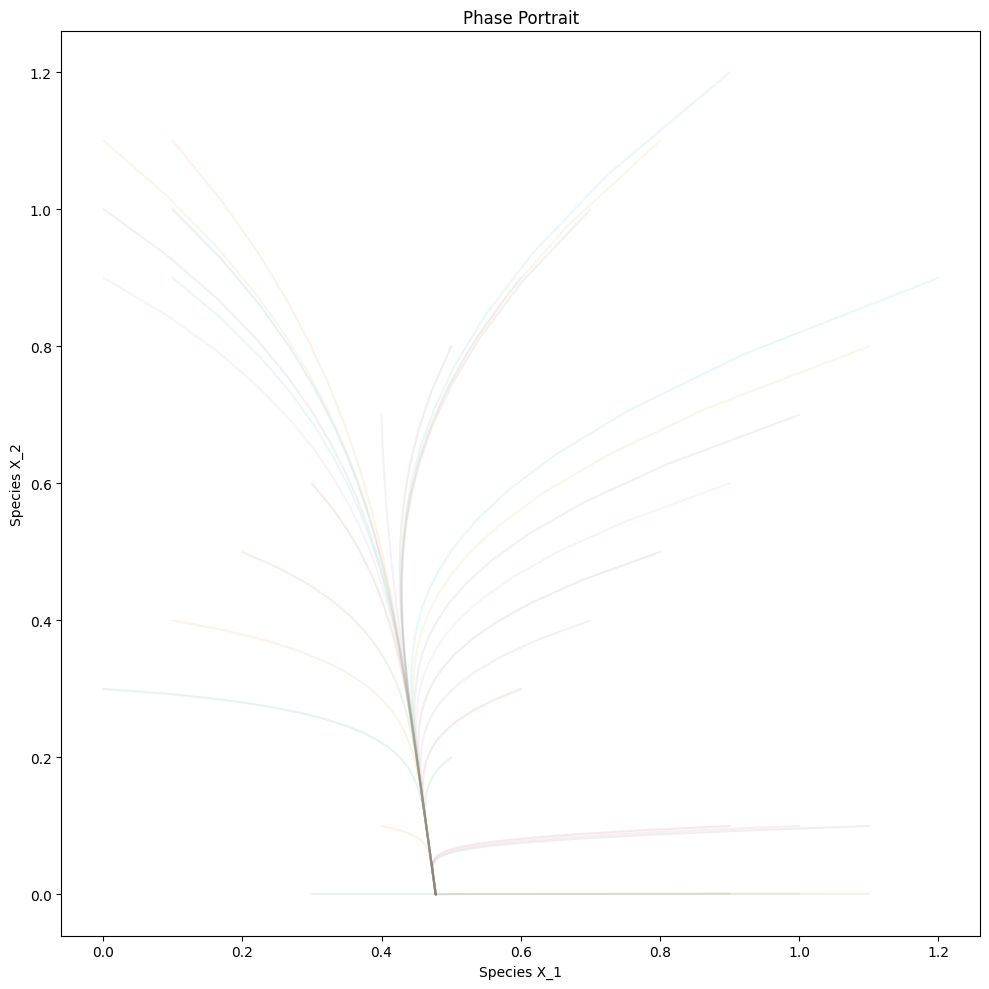

In [ ]:
crn_s.plot_phase_portrait(); plt.show()

Save again our results.

In [ ]:
trainer.save(checkpoint_path)

Saved checkpoint: classification_task_chkpt.pkl


## 11) Loading a saved Session/Trainer from a checkpoint

`load_session_and_trainer` reconstructs wiring and restores weights, history, HoFs, and RNG states.


Best CRN loss: 0.35213314708190235
Inputs: ['u_1'] 
Species: ['X_1', 'X_2'] 
Output Species: ['X_1', 'X_2'] 
∅ ----> ∅;  [MAK(0.5386638045310974)]
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 ----> ∅;  [MAK(0.3795928359031677)]
X_1 ----> X_1 + X_1;  [MAK(0.6028356552124023)]
X_1 + X_1 ----> ∅;  [MAK(0.7176306247711182)]
X_1 + X_2 ----> X_2;  [MAK(0.5970684289932251)]


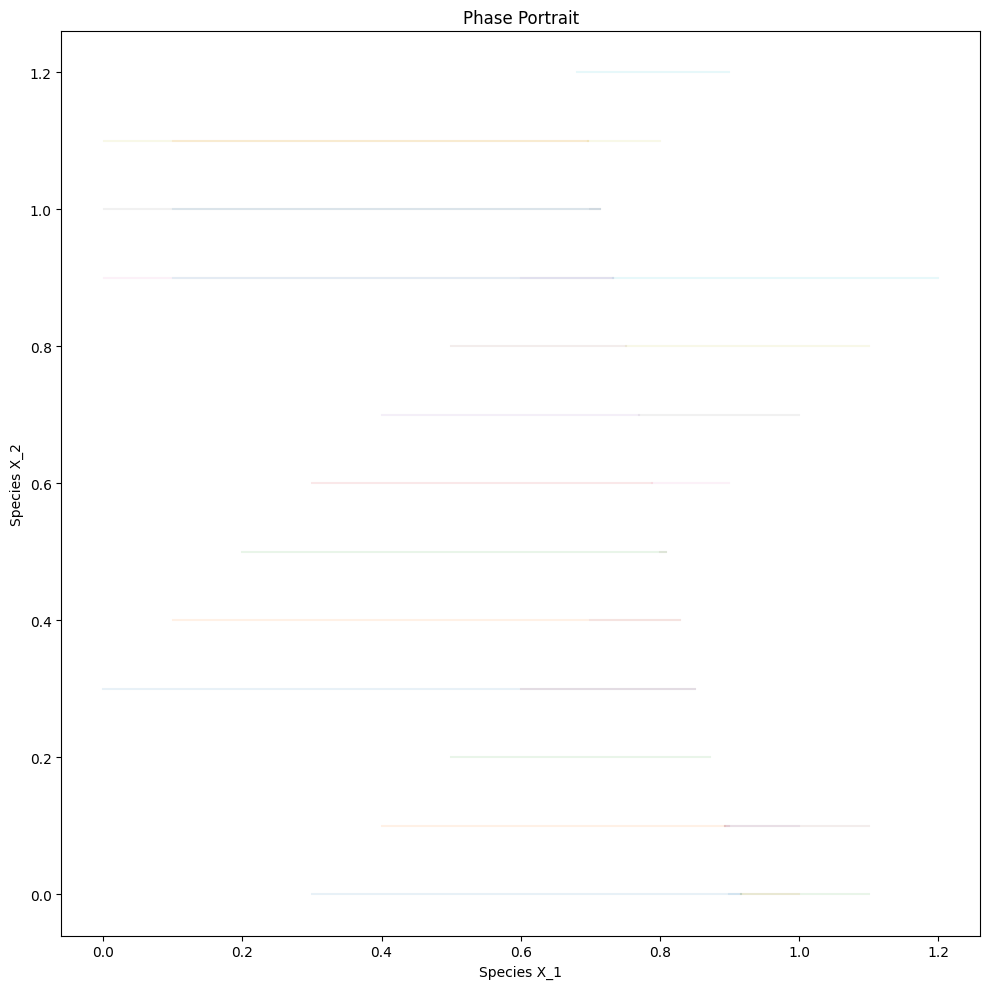

In [ ]:
from RL4CRN.utils.input_interface import load_session_and_trainer

trainer_loaded = load_session_and_trainer(checkpoint_path, device="cuda")
trainer_loaded.inspect_best()

## 12) Re-simulate Hall-of-Fame CRNs under new conditions

We can take the training Hall-of-Fame CRNs and re-simulate them under a new IC and/or new input set.

This uses `Trainer.resimulate(...)` which clones CRNs before evaluation (so old results remain intact).


CRN loss: 0.35213314708190235
Inputs: ['u_1'] 
Species: ['X_1', 'X_2'] 
Output Species: ['X_1', 'X_2'] 
∅ ----> ∅;  [MAK(0.5386638045310974)]
∅ ----> X_1;  [MAK(1.0, u_1)]
X_1 ----> ∅;  [MAK(0.3795928359031677)]
X_1 ----> X_1 + X_1;  [MAK(0.6028356552124023)]
X_1 + X_1 ----> ∅;  [MAK(0.7176306247711182)]
X_1 + X_2 ----> X_2;  [MAK(0.5970684289932251)]


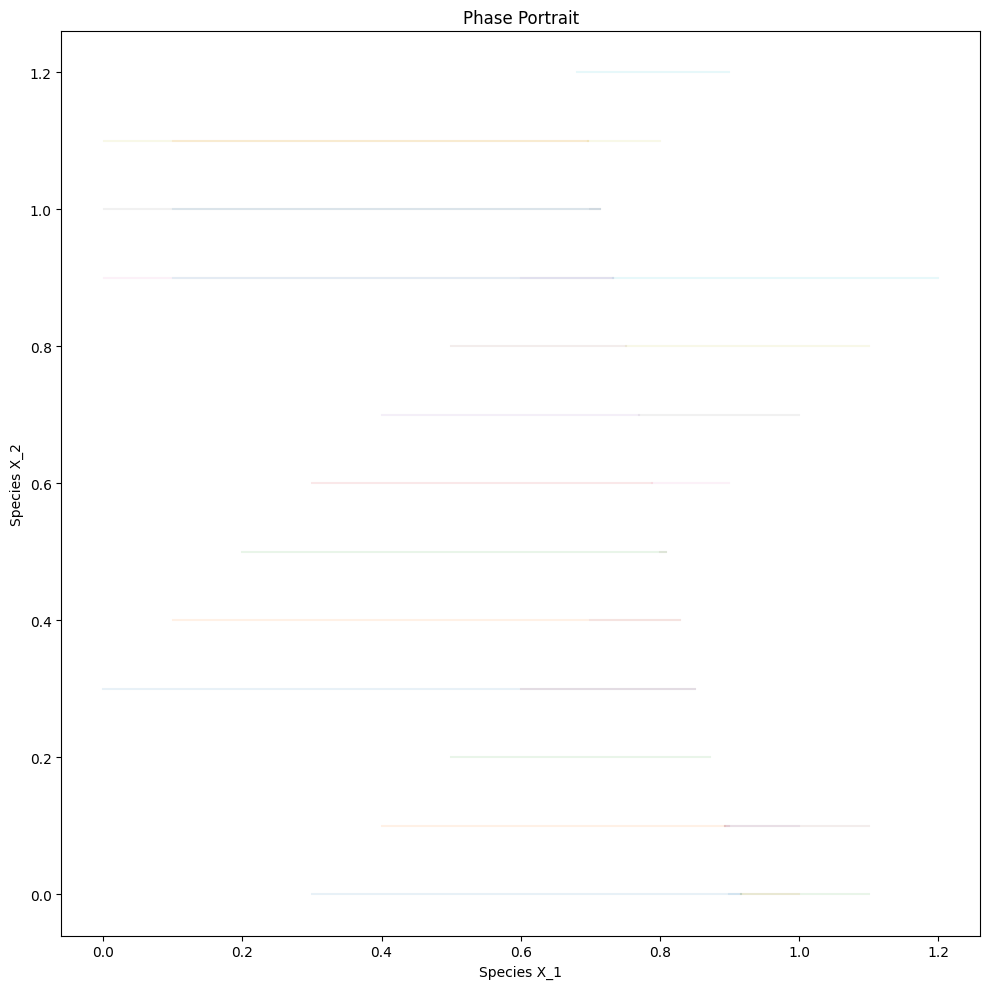

In [ ]:
hof_crns = [item.state for item in trainer.s.mult_env.hall_of_fame]

trainer.s.crn_template

crns_new = trainer.resimulate(
    hof_crns,
)

trainer.inspect(crns_new[0])
